MASE =  0.6221292706585362


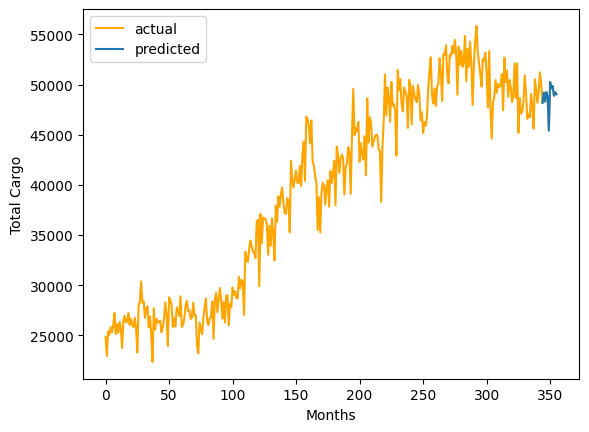

[24871.1, 22954.8, 25394.0, 25076.7, 25824.3, 25318.3, 25975.9, 27226.2, 25154.0, 26111.1, 25243.8, 26333.8, 25808.4, 23739.6, 26446.1, 26945.7, 26302.3, 26356.6, 27257.2, 26035.3, 26650.7, 26048.1, 25827.1, 26747.0, 25750.6, 23303.6, 27979.1, 28391.1, 30382.9, 28220.2, 28400.1, 26756.7, 27697.2, 27912.7, 25827.5, 26885.1, 24928.7, 22358.2, 27685.4, 25574.0, 26646.8, 26268.2, 26381.0, 26452.3, 25306.2, 25810.2, 26627.1, 28284.0, 27047.6, 23957.9, 28807.1, 28537.5, 27988.7, 25838.2, 26709.0, 25882.1, 27786.6, 27517.3, 26928.9, 28901.3, 25835.9, 26040.7, 26703.2, 27994.4, 28445.0, 27421.3, 27483.0, 26634.3, 26762.9, 28254.5, 26969.8, 27046.2, 23982.5, 23216.9, 26284.0, 25703.6, 25108.7, 26732.4, 27816.9, 28675.1, 26373.8, 26029.2, 26715.7, 26848.2, 28368.1, 24656.0, 28476.4, 29221.3, 27326.2, 28628.7, 29716.3, 28494.5, 26665.7, 28353.9, 26288.5, 28960.4, 28997.8, 25999.4, 28183.6, 27803.7, 29772.0, 29041.4, 29415.9, 28743.2, 28688.3, 30827.7, 29684.2, 30537.0, 30385.6, 27040.8, 33339.4, 

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


class MLModel:
    def __init__(self):
        self.df = pd.read_csv('../ml/cargor_model_monthly.csv')

    def reread_data(self):
        self.df = pd.read_csv('../ml/cargor_model_monthly.csv')

    def split(self):
        X = self.df['Total Cargo (Thousand Tonnes)']
        y = self.df['Month Rank']
        forecast_range = 12
        split_index = 343-forecast_range+1
        X_train = X.iloc[:split_index]
        y_train = y.iloc[:split_index]

        X_test = X[split_index:]
        y_test = y[split_index:]

        actual_train = self.df.iloc[:split_index]

        return X, y, X_train, y_train, X_test, y_test, actual_train

    def decompose(self, X):
        ts_dicomposition = seasonal_decompose(x=X, model='additive', period=12)
        trend = ts_dicomposition.trend
        self.seasonal = ts_dicomposition.seasonal
        residual = ts_dicomposition.resid

        return trend, residual

    def train_model(self):
        forecast_range = 12
        X, y, X_train, y_train, X_test, y_test, actual_train = self.split()
        trend, residual = self.decompose(X_train)

        trend_model = ARIMA(trend, order=(2, 2, 3))
        self.trend_fit = trend_model.fit()
        trend_pred = pd.Series(self.trend_fit.forecast(forecast_range))

        residual_model = ARIMA(residual, order=(1, 2, 1))
        self.residual_fit = residual_model.fit()
        residual_pred = pd.Series(self.residual_fit.forecast(forecast_range))

        start_month_forecast = actual_train.iloc[-1]['Month Num'] + 1
        n_steps = start_month_forecast+forecast_range-1 # Replace with the desired number of forecasted periods
        period_length = 12
        seasonal_pattern = self.seasonal[:12]
        seasonal_pred = np.tile(seasonal_pattern.values, n_steps // period_length + 1)[start_month_forecast-1:n_steps]

        overall_forecast = trend_pred + seasonal_pred + residual_pred

        n = np.array(X_test).shape[0]
        d = np.abs(np.diff(np.array(X_test))).sum()/(n-1)

        errors = np.abs(X_test - overall_forecast)
        MASE = errors.mean() / d
        print("MASE = ", MASE)

    def predict(self, forecast_range):
        if forecast_range > 12 or forecast_range <= 0:
            return "forecast range out of range. try between 1-12"

        trend_pred = pd.Series(self.trend_fit.forecast(forecast_range)).reset_index(drop=True)
        residual_pred = pd.Series(self.residual_fit.forecast(forecast_range)).reset_index(drop=True)
        start_month_forecast = self.df.iloc[-1]['Month Num'] + 1
        n_steps = start_month_forecast+forecast_range-1
        period_length = 12
        seasonal_pattern = self.seasonal[:12]
        seasonal_pred = np.tile(seasonal_pattern.values, n_steps // period_length + 1)[start_month_forecast-1:n_steps]

        forecast = trend_pred + residual_pred + seasonal_pred
        start_index = self.df.index[-1] + 1
        end_index = start_index+len(forecast)
        forecast.index = range(start_index, end_index)
        
        res = pd.concat([self.df['Total Cargo (Thousand Tonnes)'], forecast]).to_list()
        months = self.df['Month'].to_list()
        plt.plot(res, label='actual', color='orange')
        plt.plot(forecast, label='predicted')
        plt.legend()
        plt.xlabel('Months')
        plt.ylabel('Total Cargo')
        plt.show()
        # actual+predicted set, start and end of predicted values
        return res, months, start_index, end_index

    def test(self):
        print(self.df)

model = MLModel()
model.train_model()
f, m, start, end = model.predict(12)
print(f, m, start, end)